In [14]:
import os, sys
import pickle
from datetime import datetime
import numpy as np
import matplotlib
from matplotlib import cm
from matplotlib.patches import Arrow
from matplotlib.gridspec import GridSpec
from astropy.table import Table, Column, vstack
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from matplotlib.colors import LinearSegmentedColormap


%load_ext autoreload
%autoreload 2

sys.path.append('/Users/belugawhale/Documents/GitHub/nirhiss/')
from src.nirhiss.plotting import ers_transmission_spectra
from src.nirhiss.juliet_utils import compile_posteriors
from src.nirhiss.utils import bin_at_resolution

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

parula = np.load('/Users/belugawhale/parula_colors.npy', allow_pickle=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = Table.read('/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/ts/CMADF-WASP_39b_NIRISS_transmission_spectrum_R300.csv',
                  format='csv', comment='#')

In [3]:
def convolve_model(filename, R=300):
    model = np.loadtxt(filename)

    R0=3000.0 #cross-section resolution
    xker = np.arange(1000)-500
    sigma = (R0/R)/(2.* np.sqrt(2.0*np.log(2.0)))
    yker = np.exp(-0.5 * (xker / sigma)**2.0)
    yker /= yker.sum()
    model_to_plot=np.convolve(model[:,1],yker,mode='same') #convolving
    return model[:,0], model_to_plot

def convolve_model_xy(y, R=300):
    R0=3000.0 #cross-section resolution
    xker = np.arange(1000)-500
    sigma = (R0/R)/(2.* np.sqrt(2.0*np.log(2.0)))
    yker = np.exp(-0.5 * (xker / sigma)**2.0)
    yker /= yker.sum()
    model_to_plot=np.convolve(y,yker,mode='same') #convolving
    return model_to_plot

In [4]:
xsections = Table.read('data/contributions/xsecs/xsections.txt', format='ascii',
                       comment='#')
# units in m^2

In [5]:
no_path = 'data/contributions/models'
no_models = [os.path.join(no_path, i) for i in os.listdir(no_path) if i.endswith('.txt')]
print(no_models)
no_models = ['model_xClouds.txt', 
             'model_xCO.txt', 'model_xCO2.txt', 'model_xH2O.txt',  'model_xK.txt']

['data/contributions/models/model_xClouds.txt', 'data/contributions/models/model_xNH3.txt', 'data/contributions/models/model_xH2S.txt', 'data/contributions/models/model_xNa.txt', 'data/contributions/models/model_reference.txt', 'data/contributions/models/model_xCO.txt', 'data/contributions/models/model_xCH4.txt', 'data/contributions/models/model_xHCN.txt', 'data/contributions/models/model_xK.txt', 'data/contributions/models/model_xInhClouds.txt', 'data/contributions/models/model_xH2O.txt', 'data/contributions/models/model_xCO2.txt']


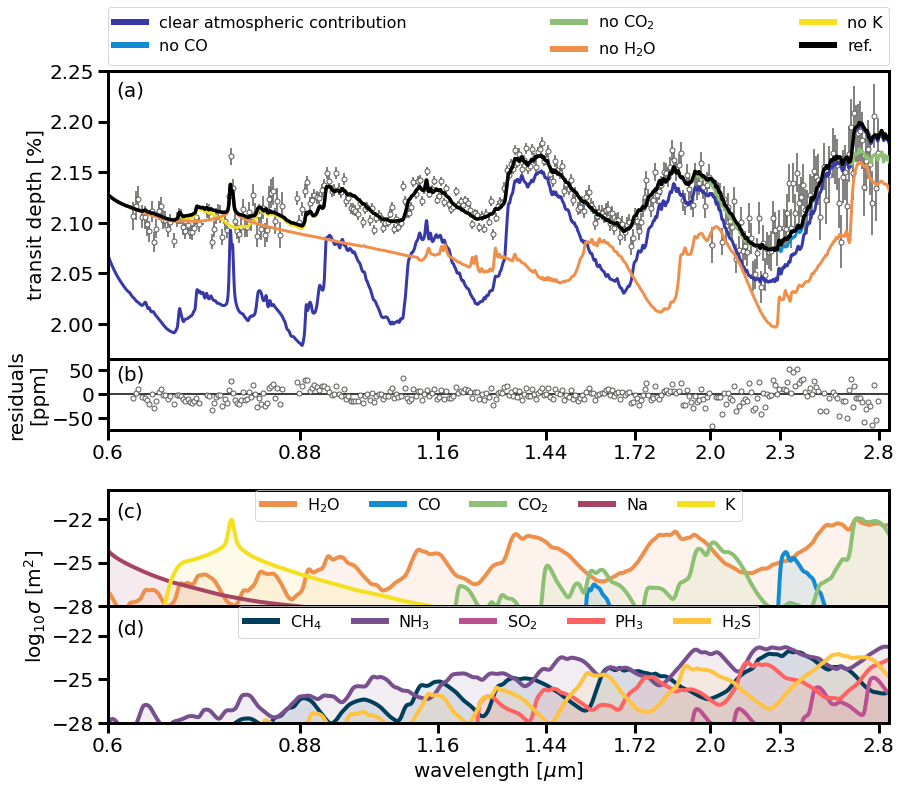

In [41]:
cutends = 15

fig = plt.figure(figsize=(14,12))
fig.set_facecolor('w')

gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[2,1.3])

gs01 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[1], hspace=0)
gs00 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0], hspace=0,
                                        height_ratios=[2,0.5])

ax1 = fig.add_subplot(gs00[0,0])
ax4 = fig.add_subplot(gs00[1,0])

ax2 = fig.add_subplot(gs01[0, 0])
ax3 = fig.add_subplot(gs01[1, 0])

dcolor = '#5c5a58'
ax1.errorbar(data['wave'], data['dppm']/1e6, 
             xerr=data['wave_error'],
             yerr=data['dppm_err']/1e6,
             linestyle='', marker='o',
             markeredgecolor=dcolor,
             ecolor=dcolor,
             color='w', zorder=1)


zorder=[2,3,4,10,5,6]
c = [10, 70, 160, 205, 240]
lw=np.full(6, 3)
labels=['clear atmospheric contribution', 'no CO', r'no CO$_2$',r'no H$_2$O',  'no K']
for i,m in enumerate(no_models):
    label=m.split('_')[-1]
    
    x, y = convolve_model(os.path.join(no_path,m))
    
    if c[i] == 205:
        xcolor = '#ee8f4b'
    else:
        xcolor=parula[c[i]]
    
    ax1.plot(x[cutends:-cutends], y[cutends:-cutends], c=xcolor,
             label=labels[i], lw=3, zorder=zorder[i])
    #c += 50
    
x, y = convolve_model('data/contributions/models/model_reference.txt')
ax1.plot(x[cutends:-cutends], y[cutends:-cutends], 'k', lw=3.5, zorder=100, label='ref.')

interp = interp1d(x[cutends:-cutends], y[cutends:-cutends])
same = interp(data['wave'])
ax4.errorbar(data['wave'], (data['dppm']/1e6-same)*100000,
             linestyle='', marker='o',
             markeredgecolor=dcolor,
             ecolor=dcolor,
             color='w')
ax4.axhline(0, color='k', zorder=0)

cols2 = ['xh2o','xco', 'xco2', 'xna', 'xk']
cols3 = ['xch4','xnh3', 'xso2', 'xph3', 'xh2s']
labels = [r'H$_2$O', 'CO', r'CO$_2$', 'Na', 'K', 
          r'CH$_4$', r'NH$_3$', r'SO$_2$', r'PH$_3$', r'H$_2$S']

cmap = plt.get_cmap('copper')

colors = cmap(np.linspace(0,1,len(cols2)+len(cols3)+2))
np.random.seed(80)
inds = np.random.choice(np.arange(0,len(cols3),1), len(cols3), 
                        replace=False)


x=0
c = [205, 70, 160, 20, 240]
for col in cols2:
    y = convolve_model_xy(xsections[col], R=100)
    q = (y > -30.5) & (xsections['wavelength'] > 0.6)
    
    if col == 'xna':
        xcolor = '#a64463'
    elif col=='xh2o':
        xcolor='#ee8f4b'
    else:
        xcolor = parula[c[x]]
    
    ax2.fill_between(xsections['wavelength'][q],
                     np.full(len(y[q]), -40), y[q], alpha=0.1,
                     color=xcolor, lw=2)
    
    ax2.plot(xsections['wavelength'][q],y[q], 
             label=labels[x], color=xcolor, lw=4)
    
    x+=1

temp = ['#003f5c', '#77508d', '#bc5090', 
        '#ff6361', '#ffc342']
g=0
for col in cols3:
    y = convolve_model_xy(xsections[col], R=100)
    q = (y > -30.5) & (xsections['wavelength'] > 0.6)
    
    if col == 'xch4':
        xcolor = '#a64463'
    else:
        xcolor = parula[c[inds[g]]]
    
    ax3.fill_between(xsections['wavelength'][q],
                     np.full(len(y[q]), -40), y[q], alpha=0.1,
                     color=temp[g], lw=2)
    ax3.plot(xsections['wavelength'][q],y[q], 
             label=labels[x], color=temp[g], lw=4)
    x+=1
    g += 1
    
for a in [ax2, ax3]:
    a.set_ylim(-28, -20)
    a.set_xlim(0.6,2.8)
    a.set_yticks([-28, -25, -22])
ax4.set_ylim(-75,75)


leg = ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                 ncol=3, mode="expand", borderaxespad=0., 
                 fontsize=16)
for legobj in leg.legendHandles:
    legobj.set_linewidth(6.0)
    
for a in [ax2, ax3]:
    leg = a.legend(ncol=5, borderaxespad=0.0, 
                   fontsize=16, loc="upper center")
    for legobj in leg.legendHandles:
        legobj.set_linewidth(6.0)

for a in [ax1, ax3, ax4]:
    a.set_xlim(0.6,2.86)
    a.set_xscale('log')
    xticks = np.append(np.linspace(0.6,2,6), np.linspace(2.3,2.8,2))
    xticks = np.round(xticks,2)
    a.set_xticks(xticks)
    a.set_xticklabels(np.round(xticks,2))

for a in [ax1, ax2]:
    a.set_xlim(0.6,2.86)
    a.set_xscale('log')
    a.set_xticks([0.6])
    a.set_xticklabels([''])

ax3.set_xlabel('wavelength [$\mu$m]')
ax1.set_ylabel('transit depth [%]')
ax4.set_ylabel('residuals\n[ppm]')
ax3.set_ylabel(r'log$_{10}\sigma$ [m$^2$]', y=1)

ax1.minorticks_off()
ax4.minorticks_off()
plt.minorticks_off()

yticks = np.round(np.arange(0.020, 0.0230, 0.0005),4)
ax1.set_yticks(yticks)
labels = np.round(yticks*100,2)
labels = [format(i, '.2f') for i in labels]
ax1.set_yticklabels(labels)

ax1.text(s='(a)', x=0.61, y=0.02225, fontsize=20)
ax4.text(s='(b)', x=0.61, y=30, fontsize=20)
ax2.text(s='(c)', x=0.61, y=-21.9, fontsize=20)
ax3.text(s='(d)', x=0.61, y=-21.9, fontsize=20)

plt.savefig(#'/Users/belugawhale/Desktop/contribution.png',
            '/Users/belugawhale/Documents/niriss_real/wasp39/paper_figures/contribution.pdf',
             dpi=250,
            rasterize=True, bbox_inches='tight')